# import modules

In [2]:
import requests
import numpy as np
import pandas as pd
from pubchempy import Compound, get_compounds
from matplotlib import pyplot as plt
import seaborn as sns
from urllib import request
from brendapyrser import BRENDA
import html
import pickle
from math import exp
from feature_functions import *
import random
import re
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

/opt/anaconda3/envs/Uni_test/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
# brenda = BRENDA('../brenda_2025_1.txt')    # replace the txt file to your downloaded file.
brenda = BRENDA('../brenda.txt')
# rxns = brenda.reactions
# print("Total reactions:", len(rxns))

# kcat_count = 0
# for r in rxns:
#     if r.Kcatvalues:
#         for sub in r.Kcatvalues:
#             kcat_count += len(r.Kcatvalues[sub])

# print("Total Kcat values:", kcat_count)

Minimum and maximum values in database: 5.83e-10 1/s, 997.0 1/s


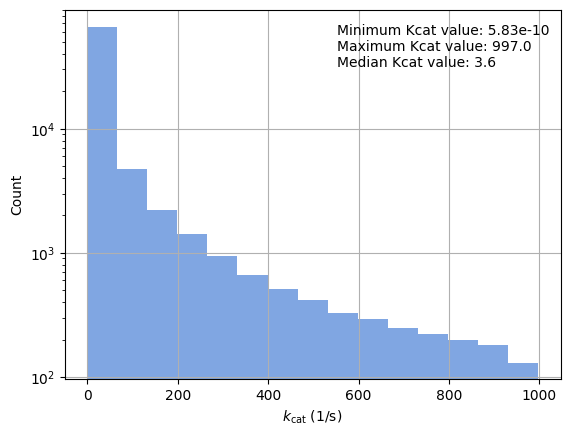

In [15]:
# Plot all Km values in the database
BRENDA_Kcats = np.array(
    [v for r in brenda.reactions for v in r.Kcatvalues.get_values()]
)
values = BRENDA_Kcats[(BRENDA_Kcats < 1000) & (BRENDA_Kcats >= 0)]
plt.hist(values, bins=15, color=(128/255, 166/255, 226/255))
plt.yscale('log')  # 设置纵坐标为以10为底的对数刻度
# plt.title(f"Median Kcat value: {np.median(values)}")
plt.xlabel("$k_\mathrm{cat}$ (1/s)")
plt.ylabel("Count")
plt.text(0.55, 0.9, f"Minimum Kcat value: {values.min()} \nMaximum Kcat value: {values.max()} \nMedian Kcat value: {np.median(values)}", 
         horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
plt.grid()
# plt.show()
print(f"Minimum and maximum values in database: {values.min()} 1/s, {values.max()} 1/s")
# plt.savefig('median_kcat.pdf', dpi=300, bbox_inches='tight')

Minimum and maximum values in database: 0.0 °C, 125.0 °C


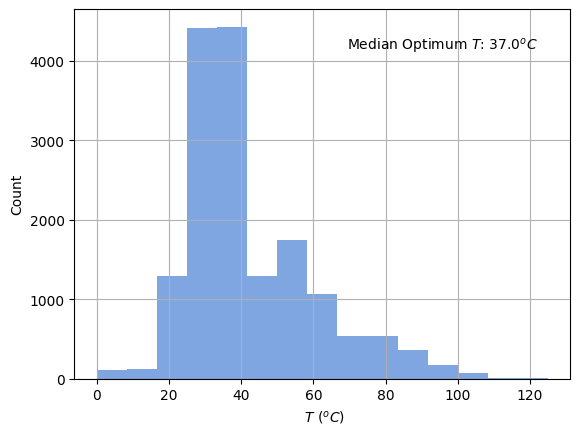

In [16]:
# Plot all enzyme optimal temperature values in the database
BRENDA_TO = np.array(
    [
        v
        for r in brenda.reactions
        for v in r.temperature.filter_by_condition("optimum").get_values()
    ]
)
values = BRENDA_TO[(BRENDA_TO >= 0)]
plt.hist(values, bins=15, color=(128/255, 166/255, 226/255))
plt.text(0.55, 0.9, f"Median Optimum $T$: {np.median(values)}$^oC$", 
         horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
plt.ylabel("Count")
plt.grid()
# plt.title(f"Median Optimum Temperature: {np.median(values)}")
plt.xlabel(" $T$ (${}^oC$)")
# plt.show()
print(f"Minimum and maximum values in database: {values.min()} °C, {values.max()} °C")
# plt.savefig('temperature.pdf', dpi=300, bbox_inches='tight')

from https://github.com/SizheQiu/DLTKcat/blob/main/code/GetData.ipynb

In [6]:
def get_smiles(substrate):
    try :
        url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/%s/property/CanonicalSMILES/TXT'%substrate
        req = requests.get(url)
        if req.status_code != 200:
            smiles = 'NaN'
        else:
            smiles = req.content.splitlines()[0].decode()
    except :
        smiles = 'NaN'
    return smiles

def get_seq(ID):
    url = "https://www.uniprot.org/uniprot/%s.fasta" % ID
    try :
        data = requests.get(url)
        if data.status_code != 200:
            seq = 'NaN'
        else:
            seq =  "".join(data.text.split("\n")[1:])
    except :
        seq = 'NaN'
    return seq

def check_mutations(seq, mut_list):
    no_error = True
    for mut in mut_list:
        ind = int(mut[1:-1])-1
        old = mut[0].upper()
        if (ind > len(seq)-1) or (seq[ind] != old):
            no_error = False
            break
    return no_error

def apply_mutations(seq, mut_list):
    mut_seq = seq
    for mut in mut_list:
        ind = int(mut[1:-1])-1
        new = mut[-1].upper()
        temp_list = list(mut_seq)
        temp_list[ind] = new
        mut_seq = ''.join(temp_list)
    return mut_seq

In [72]:
brenda_ec_list = []
for rxn in brenda.reactions:
    brenda_ec_list.append( rxn.ec_number )
brenda_ec_list = list(set(brenda_ec_list))
print(len(brenda_ec_list))

7754


In [73]:
QUERY_URL = 'http://sabiork.h-its.org/sabioRestWebServices/kineticlawsExportTsv'

with open('../enzyme.dat', 'r') as outfile :
    lines = outfile.readlines()

ec_list = []
for line in lines :
    if line.startswith('ID') :
        ec = line.strip().split('  ')[1]
        ec_list.append(ec.strip())
# print(ec_list)
print(len(ec_list))

8401


# download kcat data from brenda

In [74]:
import re
import html

def extract_temperature(meta):
    match = re.search(r'(\d+(\.\d+)?)\s*°C', meta)
    if match:
        return float(match.group(1))
    return None

def get_entry_kcat(ec, skill_num):
    r = brenda.reactions.get_by_id(ec)
    all_data = r.Kcatvalues
    result = []
    for sub in all_data.keys():
        sub_data = all_data[sub]
        for entry in sub_data:
            meta = entry['meta'].replace('Â°C', '°C')  # 编码修正

            # 过滤条件
            if ('°C' not in meta) or ('#' not in meta) or (';' in meta) or ('specified' in meta):
                continue

            # 提取温度
            temperature = extract_temperature(meta)
            if temperature is None:
                skill_num += 1
                continue

            value = entry['value']

            # 判断是否为野生型或突变型
            if 'mutant' not in meta:
                enz_type = 'WT'
                mutation = 'None'
            else:
                mut4 = re.findall(r'[A-Z][0-9]{4}[A-Z]', meta)
                mut3 = re.findall(r'[A-Z][0-9]{3}[A-Z]', meta)
                mut2 = re.findall(r'[A-Z][0-9]{2}[A-Z]', meta)
                mut1 = re.findall(r'[A-Z][0-9]{1}[A-Z]', meta)
                mut_list = mut4 + mut3 + mut2 + mut1
                if len(mut_list) < 1:
                    continue
                enz_type = 'MUT'
                mutation = '/'.join(mut_list)

            # 提取蛋白质参考
            try:
                p_ref = meta.split('#')[1].strip()
            except IndexError:
                continue

            p_ref_list = [ref.strip() for ref in p_ref.split(',')]
            p_ids = []
            for ref in p_ref_list:
                if ref in r.proteins:
                    pid = r.proteins[ref]['proteinID']
                    if pid:
                        p_ids.append(pid)

            for p_id in p_ids:
                result.append({
                    'EC': ec,
                    'temperature': temperature,
                    'sub': sub,
                    'UniProtID': p_id,
                    'EnzymeType': enz_type,
                    'Mutation': mutation,
                    'kcat': float(value)
                })
    return result, skill_num


In [75]:
from decimal import Decimal
result = []
idx = 0
skill_num=0
for ec in brenda_ec_list:
    if idx % 500 == 0:
        print(str(idx) + ' done')
    result_tmp, skill_num_tmp = get_entry_kcat(ec, skill_num)
    result += result_tmp
    skill_num += skill_num_tmp
    idx+=1
print(len(result))
skill_num_dec = Decimal(skill_num)
print(f'Total skill_num: {skill_num_dec:.3E}')


0 done
500 done
1000 done
1500 done
2000 done
2500 done
3000 done
3500 done
4000 done
4500 done
5000 done
5500 done
6000 done
6500 done
7000 done
7500 done
23731
Total skill_num: 9.401E+2278


In [76]:
rawdata_brenda = pd.DataFrame(result)
rawdata_brenda = (rawdata_brenda[rawdata_brenda['kcat']>0]).dropna().reset_index().drop(['index'],axis=1)
proteinIDs = []
for i in range(len(rawdata_brenda['UniProtID'])):
    ID = list( rawdata_brenda['UniProtID'] )[i]
    proteinIDs.append( ID.split(' ')[0] )
rawdata_brenda['UniProtID'] =  proteinIDs   
rawdata_brenda.head(10)  

,EC,temperature,sub,UniProtID,EnzymeType,Mutation,kcat
0,1.1.1.51,25.0,NADH,A0A097ZMZ1,WT,None,0.100
1,1.1.1.51,25.0,"5beta-androstane-3beta,17beta-diol",A0A097ZMZ1,WT,None,0.036
2,1.1.1.51,25.0,2-Cyclohexen-1-ol,A0A097ZMZ1,WT,None,0.040
3,1.1.1.51,25.0,dehydroepiandrosterone,A0A097ZMZ1,WT,None,0.010
4,1.1.1.51,25.0,NADP+,A0A097ZMZ1,WT,None,0.150
5,1.1.1.51,25.0,NAD+,A0A097ZMZ1,WT,None,0.110
6,1.1.1.51,25.0,trans-benzene dihydrodiol,A0A097ZMZ1,WT,None,0.033
7,1.1.1.51,25.0,cis-benzene dihydrodiol,A0A097ZMZ1,WT,None,0.025
8,1.1.1.51,25.0,"(S)-1,2,3,4-tetrahydro-1-naphthol",A0A097ZMZ1,WT,None,0.025
9,1.1.1.51,25.0,beta-3-hydroxyhexobarbital,A0A097ZMZ1,WT,None,0.025


In [77]:
kcat_brenda = []
total = len(rawdata_brenda['sub'])


for i in range(len(rawdata_brenda['sub'])):
    ec, T, sub, pid, enz_type, muts, kcat = rawdata_brenda.iloc[i]
    data={'EC':ec,'Temp':T,'sub':sub,'ProtID':pid,'EnzymeType':enz_type,'Mutation':muts,'kcat':kcat}
    data['smiles']=get_smiles( sub )
    if data['smiles']  == 'NaN' or data['smiles'] == '':
        continue
    temp_seq = get_seq( pid )
    if temp_seq == 'NaN' or temp_seq == '':
        continue
    if enz_type == 'WT':
        data['seq'] = temp_seq
    else:
        mut_list = muts.split('/')
        if check_mutations(temp_seq, mut_list):
            temp_seq = apply_mutations(temp_seq, mut_list)
            data['seq'] = temp_seq
        else:
            continue
              
    kcat_brenda.append(data)
    if i%2000 == 0: #2000
        print(str(i/total)+'% done')

In [ ]:
raw_kcat_brenda = pd.DataFrame( kcat_brenda )
raw_kcat_brenda = raw_kcat_brenda.dropna().reset_index().drop(['index'],axis=1)

In [ ]:
# raw_kcat_brenda.to_csv('../data/raw_kcat_brenda_2025.csv',index = None)

# extract info from sabiork

In [ ]:
# # download data from sabiork
f = open('../data/raw_data.txt','w')
i=0
for ec in ec_list :
    query_dict = {"ECNumber":'%s' %ec,}
    query_string = ' AND '.join(['%s:%s' % (k,v) for k,v in query_dict.items()])
    query = {'fields[]':['EntryID', 'Substrate', 'EnzymeType', 'PubMedID', 'Organism', 
                         'UniprotID','ECNumber','Parameter','Temperature'], 'q':query_string}
    request = requests.post(QUERY_URL, params = query)
    results = request.text
    if i >0:
        results = results.replace("EntryID\tSubstrate\tEnzymeType\tPubMedID\tOrganism\tUniprotID\tECNumber\tparameter.type\tparameter.associatedSpecies\tparameter.startValue\tparameter.endValue\tparameter.standardDeviation\tparameter.unit\tTemperature\n",'')
    f.write(results)
    if i%100 == 0:
        print(i)
    i=i+1
f.close()

In [3]:
#unit of kcat is 1/s
kcat_uni = []
with open('../data/raw_data.txt') as file:
    lines = file.readlines()
    for l in lines:
        l=l.replace('\n','').strip()
        params = l.split('\t')
        if len(params)!=14:
            continue
        if params[7] != 'kcat':
            continue
        if params[9] == '':
            continue
            
        data = {}
        data['Organism']=params[4]
        data['UniprotID']=params[5]
        data['EC']=params[6]
        data['Temperature']=params[13]
        if data['UniprotID'] == '-' or data['Temperature']=='-' or data['UniprotID'] == '' or data['Temperature']=='':
            continue
        
        if 'mutant' not in params[2]:
            enz_type = 'WT'
            mutation = 'None'
        else:
            mut4 = re.findall('[A-Z][0-9][0-9][0-9][0-9][A-Z]',params[2])
            mut3 = re.findall('[A-Z][0-9][0-9][0-9][A-Z]',params[2])
            mut2 = re.findall('[A-Z][0-9][0-9][A-Z]',params[2])
            mut1 = re.findall('[A-Z][0-9][A-Z]',params[2])
            mut_list = mut4 + mut3 + mut2 + mut1
            if len(mut_list) < 1:
                continue
            else:
                enz_type = 'MUT'
                mutation = '/'.join(mut_list)
        data['EnzymeType'] = enz_type
        data['Mutation'] = mutation
        if params[7] == 'kcat':
            if params[12]!='s^(-1)':
                continue
            #remove h2o and h+
            substrates = params[1].replace('H2O;','').replace(';H2O','').replace('H+;','').replace(';H+','')
            #remove cofactors
            cofactors = ['FADH2','FAD','NAD+','NADH']
            if ';' in substrates:
                for cof in cofactors:
                    substrates = substrates.replace(';'+cof,'').replace(cof+';','')
                    
            subs = substrates.split(';')
            
            if len(subs) == 1:
                data['sub']=subs[0]
                data['kcat']=params[9]
                data['unit']=params[12]
                kcat_uni.append(data)      
        else:
            continue           

In [4]:
kcat_table_uni = pd.DataFrame(kcat_uni).dropna()
kcat_table_uni = kcat_table_uni.dropna().drop_duplicates().reset_index().drop(['index'],axis=1)

# Process kcat from sabiork

In [7]:
uni = []
total = len(kcat_table_uni['sub'])

for i in range(len(kcat_table_uni['sub'])):
    if i%1000 == 0:
        print( str(i/total)+'% done' ) 
        
    data={'EC':list(kcat_table_uni['EC'])[i],'Temp':float( list(kcat_table_uni['Temperature'])[i] ),
          'kcat':float( list(kcat_table_uni['kcat'])[i]), 'sub':list(kcat_table_uni['sub'])[i],
          'ProtID': list(kcat_table_uni['UniprotID'])[i], 'EnzymeType':list(kcat_table_uni['EnzymeType'])[i],
          'Mutation':list(kcat_table_uni['Mutation'])[i] }
    
    data['smiles']=get_smiles( list(kcat_table_uni['sub'])[i] )
    if data['smiles'] == 'NaN' or data['smiles'] == '':
        continue
    temp_seq =get_seq( list(kcat_table_uni['UniprotID'])[i] )
    if temp_seq == 'NaN' or temp_seq == '':
        continue
        
    if data['EnzymeType'] == 'WT':
        data['seq'] = temp_seq
    else:
        mut_list = data['Mutation'].split('/')
        if check_mutations(temp_seq, mut_list):
            temp_seq = apply_mutations(temp_seq, mut_list)
            data['seq'] = temp_seq
        else:
            continue
        
    uni.append(data)

0.0% done


In [68]:
uni_table=pd.DataFrame(uni)
uni_table = uni_table.dropna().drop_duplicates().reset_index().drop(['index'],axis=1)
print(len(uni_table))
# uni_table.to_csv('../data/raw_kcat_sa.csv',index=None)

0


# merge kcat data from brenda and sabiork
## - check conflicts(pick the largest one), kcat > 0, unique compound-protein pairs

In [ ]:
raw_kcat_brenda = pd.read_csv('../data/raw_kcat_brenda.csv')
raw_kcat_brenda = raw_kcat_brenda[['EC','sub', 'ProtID', 'EnzymeType', 'Mutation',
                                   'kcat','Temp','smiles', 'seq']]
raw_kcat_brenda['source'] = ['brenda' for i in range(len(raw_kcat_brenda['EC']))]
print( len(raw_kcat_brenda['EC']) )
raw_kcat_sa = pd.read_csv('../data/raw_kcat_sa.csv')
raw_kcat_sa = raw_kcat_sa[['EC','sub', 'ProtID', 'EnzymeType', 'Mutation',
                                   'kcat','Temp','smiles', 'seq']]
raw_kcat_sa['source'] = ['sabiork' for i in range(len(raw_kcat_sa['EC']))]
print( len(raw_kcat_sa['EC']) )

kcat_merge =  (pd.concat([raw_kcat_sa,raw_kcat_brenda]) ).reset_index().drop(['index'],axis=1)
print( len(kcat_merge['EC']) )

In [ ]:
keep_uni = []
for i in range( len(kcat_merge['EC']) ):
    T, smiles, seq = list(kcat_merge['Temp'])[i], list(kcat_merge['smiles'])[i], list(kcat_merge['seq'])[i]
    temp_table = kcat_merge[ (kcat_merge['Temp']==T)&(kcat_merge['smiles']==smiles)&(kcat_merge['seq']==seq)]
    temp_table = temp_table.sort_values(by=['kcat'],ascending=False)
    keep_uni.append(temp_table.index[0])
keep_uni = list(set(keep_uni))
kcat_merge = ( kcat_merge.iloc[keep_uni] ).reset_index().drop(['index'],axis=1)
print( len(kcat_merge['EC']) )

In [ ]:
TC_list = list(kcat_merge['Temp'])
kcat_merge['Inv_Temp'] = [ 1/float(T+273.15) for T in TC_list]

In [ ]:
kcat_merge = kcat_merge[ ['EC', 'sub', 'ProtID', 'EnzymeType', 'Mutation', 'kcat', 'Temp', 'Inv_Temp',
       'smiles', 'seq', 'source'] ]
kcat_merge.head()

# Remove metal ions and smiles with isolated parts from entries

In [ ]:
ions = ['[Fe+3]','[Fe+2]','[Zn+2]','[Cu+2]','[K+]','[Ca+2]','[Hg+2]','[Mg+2]','[Mn+2]','[Mg+2]','[S-2]',
              '[Cd+2]','[Co+2]','[Ag+]','[Cr+6]','[Cs+]','[F-]','[Br-]','[Cl-]','[I-]','[Na+]','[Ni+2]','[No]','[Mo]']
rm_ind = []
for i in range( len(kcat_merge['smiles']) ):
    if '.' in list( kcat_merge['smiles'] )[i]:
        rm_ind.append(i)
        continue
        
    for ion in ions:
        if ion in list( kcat_merge['smiles'] )[i]:
            rm_ind.append(i)
rm_ind = list(set(rm_ind))
kcat_merge = ( kcat_merge.drop(rm_ind) ).reset_index().drop(['index'],axis=1) 

In [ ]:
kcat_merge =( kcat_merge[kcat_merge['kcat']>0]).reset_index().drop(['index'],axis=1) 
print( len(kcat_merge['EC']) )

In [ ]:
# kcat_merge.to_csv('../data/kcat_merge.csv',index=None)

# Additional molecular properties of substrates (x)
* MW, logP, MR, TPSA, labuteasa, fractioncsp3, hba, hbd;

In [ ]:
# kcat_merge = pd.read_csv('../data/kcat_merge.csv')
# print(kcat_merge.columns)
# kcat_merge.head()

In [ ]:
# def calc_addifeatures(smiles):
#     mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
#     mw = Chem.rdMolDescriptors.CalcExactMolWt(mol)
#     logp, mr = Chem.rdMolDescriptors.CalcCrippenDescriptors(mol)
#     tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
#     labuteasa = Chem.rdMolDescriptors.CalcLabuteASA(mol)
#     fcsp3 = Chem.rdMolDescriptors.CalcFractionCSP3(mol)
#     hba = Chem.rdMolDescriptors.CalcNumLipinskiHBA(mol)
#     hbd = Chem.rdMolDescriptors.CalcNumLipinskiHBD(mol)
#     return {'mw':mw, 'logp':logp, 'mr':mr, 'tpsa':tpsa, 'labuteasa':labuteasa, 
#             'fcsp3':fcsp3, 'hba':hba, 'hbd':hbd}

In [ ]:
# addi_features = []
# for i in range(len(kcat_merge['smiles'])):
#     smiles = list( kcat_merge['smiles'] )[i]
#     addi_features.append( calc_addifeatures(smiles) )
# addi_table = pd.DataFrame(addi_features)
# print(addi_table.columns)

In [ ]:
# kcat_merge = pd.concat([kcat_merge,addi_table],axis=1)
# kcat_merge = kcat_merge[['EC', 'sub', 'ProtID', 'EnzymeType', 'Mutation', 'smiles', 'seq','Temp',\
#                          'mw', 'logp', 'mr', 'tpsa', 'labuteasa', 'fcsp3', 'hba', 'hbd','kcat', 'source']]
# EC = [x.replace('()','').strip() for x in list(kcat_merge['EC'])]
# kcat_merge['EC'] = EC
# kcat_merge.head()

# Assign enzyme pathways

In [3]:
kcat_merge = pd.read_csv('../data/kcat_merge.csv')
TC_list = list(kcat_merge['Temp'])
kcat_merge['Temp_K'] = [ float(T+273.15) for T in TC_list]
kcat_merge = kcat_merge[ ['EC', 'sub', 'ProtID', 'EnzymeType', 'Mutation', 'kcat', 'Temp', 'Temp_K',
       'Inv_Temp', 'smiles', 'seq', 'source']]
EC = [x.replace('()','').strip() for x in list(kcat_merge['EC'])]
kcat_merge['EC'] = EC
kcat_merge.head()

,EC,sub,ProtID,EnzymeType,Mutation,kcat,Temp,Temp_K,Inv_Temp,smiles,seq,source
0,1.1.1.1,Ethanol,P49384,WT,None,408.33330,25.0,298.15,0.003354,CCO,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork
1,1.1.1.1,Acetaldehyde,P49384,WT,None,1143.33300,25.0,298.15,0.003354,CC=O,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork
2,1.1.1.1,1-Butanol,P06757,WT,None,14.33333,25.0,298.15,0.003354,CCCCO,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork
3,1.1.1.1,Butanal,P06757,WT,None,156.00000,25.0,298.15,0.003354,CCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork
4,1.1.1.1,1-Octanal,P06757,WT,None,390.00000,25.0,298.15,0.003354,CCCCCCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork


In [4]:
ec_module = pd.read_csv('../data/module_ec.txt',sep='\t',header=None)
ec_module = ec_module.drop([0],axis=1)
ec_module = ec_module.rename(columns = {1:'EC',2:'Pathway'})
print(np.unique(ec_module['Pathway']) )
enz_paths = {'Primary':set(),'Secondary':set()}
for i in range( len(ec_module['EC']) ):
    ec = list(ec_module['EC'])[i].replace('EC','').strip()
    if 'Primary' in list(ec_module['Pathway'])[i]:
        enz_paths['Primary'].add(ec)
    else:
        enz_paths['Secondary'].add(ec)

['Intermediate' 'Primary - Carbohydrate & Energy Metabolism'
 'Primary - amino acids, fatty acids and nucleotides' 'Secondary'
 'Secondary_other' 'x']


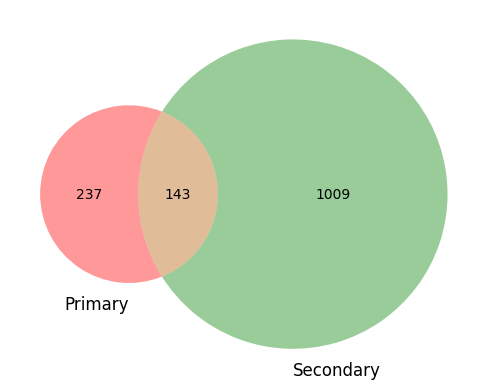

In [5]:
from matplotlib_venn import venn2
venn2([enz_paths['Primary'],enz_paths['Secondary']], ['Primary','Secondary'])

In [6]:
pathway = []
for i in range(len(kcat_merge['EC'])):
    if list( kcat_merge['EC'] )[i] in enz_paths['Primary']:
        pathway.append('Primary')
    elif list( kcat_merge['EC'] )[i] not in (enz_paths['Primary'] | enz_paths['Secondary']):
        pathway.append('Un-annotated')
    else:
        pathway.append('Secondary')
kcat_merge['pathway'] = pathway
kcat_merge.head()      

,EC,sub,ProtID,EnzymeType,Mutation,kcat,Temp,Temp_K,Inv_Temp,smiles,seq,source,pathway
0,1.1.1.1,Ethanol,P49384,WT,None,408.33330,25.0,298.15,0.003354,CCO,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary
1,1.1.1.1,Acetaldehyde,P49384,WT,None,1143.33300,25.0,298.15,0.003354,CC=O,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary
2,1.1.1.1,1-Butanol,P06757,WT,None,14.33333,25.0,298.15,0.003354,CCCCO,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary
3,1.1.1.1,Butanal,P06757,WT,None,156.00000,25.0,298.15,0.003354,CCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary
4,1.1.1.1,1-Octanal,P06757,WT,None,390.00000,25.0,298.15,0.003354,CCCCCCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary


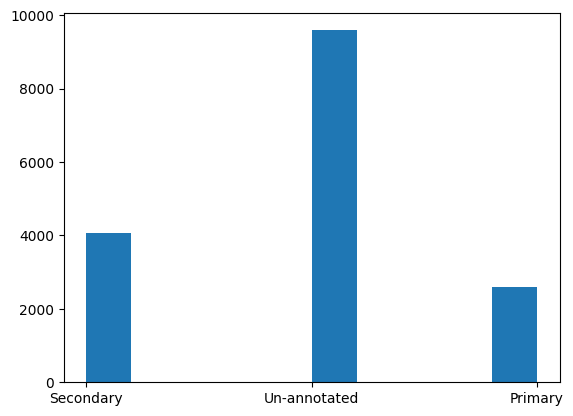

In [7]:
plt.hist(kcat_merge['pathway']);

In [ ]:
# kcat_merge.to_csv('../data/kcat_merge.csv',index=None)

# Random oversampling entries of low and high temperatures
* 6000 duplicates for T >= 40C
* 2000 duplicates for T <= 20C

In [8]:
kcat_merge = pd.read_csv('../data/kcat_merge.csv')

In [ ]:
# high_set = (kcat_merge[kcat_merge['Temp']>=40]).reset_index().drop(['index'],axis=1)
# low_set = (kcat_merge[kcat_merge['Temp']<=20]).reset_index().drop(['index'],axis=1)
# over_low, over_high = [],[]
# for i in range( 2*len(high_set.index) ):
#     rand_idx = np.random.randint( len(high_set['EC'] ) - 1,size=1)[0]
#     temp_data = dict( high_set.iloc[rand_idx] )
#     over_high.append( temp_data )
# for i in range( 2*len(low_set.index) ):
#     rand_idx = np.random.randint( len(low_set['EC'] ) - 1,size=1)[0]
#     temp_data = dict( low_set.iloc[rand_idx] )
#     over_low.append( temp_data )
# over_set = over_low + over_high
# random.shuffle(over_set)
# over_pd = pd.DataFrame(over_set)

In [ ]:
# process_pd = ( pd.concat([ kcat_merge, over_pd]) ).reset_index().drop(['index'],axis=1)
# T_K_norm = scale_minmax(process_pd['Temp_K'], min(process_pd['Temp_K']) , max(process_pd['Temp_K']))
# inv_T_norm = scale_minmax(process_pd['Inv_Temp'], min(process_pd['Inv_Temp']) , max(process_pd['Inv_Temp']))
# process_pd['Temp_K_norm'] = T_K_norm
# process_pd['Inv_Temp_norm'] = inv_T_norm

In [9]:
process_pd = pd.read_csv('../data/processed_data.csv')
process_pd.head()

,EC,sub,ProtID,EnzymeType,Mutation,kcat,Temp,Temp_K,Inv_Temp,smiles,seq,source,pathway,Temp_K_norm,Inv_Temp_norm
0,1.1.1.1,Ethanol,P49384,WT,None,408.33330,25.0,298.15,0.003354,CCO,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary,0.25,0.687112
1,1.1.1.1,Acetaldehyde,P49384,WT,None,1143.33300,25.0,298.15,0.003354,CC=O,MLRLTSARSIVSPLRKGAFGSIRTLATSVPETQKGVIFYENGGKLE...,sabiork,Secondary,0.25,0.687112
2,1.1.1.1,1-Butanol,P06757,WT,None,14.33333,25.0,298.15,0.003354,CCCCO,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112
3,1.1.1.1,Butanal,P06757,WT,None,156.00000,25.0,298.15,0.003354,CCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112
4,1.1.1.1,1-Octanal,P06757,WT,None,390.00000,25.0,298.15,0.003354,CCCCCCCC=O,MSTAGKVIKCKAAVLWEPHKPFTIEDIEVAPPKAHEVRIKMVATGV...,sabiork,Secondary,0.25,0.687112


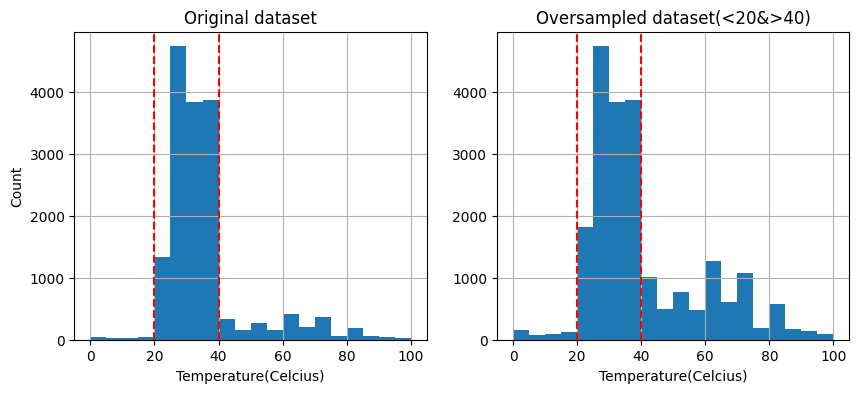

In [10]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].hist(kcat_merge['Temp'],bins=20);
axs[1].hist(process_pd['Temp'],bins=20);
axs[0].set_title('Original dataset')
axs[0].set_ylabel('Count')
axs[1].set_title('Oversampled dataset(<20&>40)')
for ax in axs:
    ax.set_xlabel('Temperature(Celcius)')
    ax.axvline(x=20,color='r', linestyle='--')
    ax.axvline(x=40,color='r', linestyle='--')
    ax.grid()

In [ ]:
# process_pd.to_csv('../data/processed_data.csv',index=None)

# Dataset split

In [ ]:
process_pd = pd.read_csv('../data/processed_data.csv')
process_pd.head()

In [ ]:
ratio = 0.1
idx = np.arange( len( process_pd['EC']) )
np.random.shuffle(idx)
num_split = int( len( process_pd['EC']) * ratio)
idx_test, idx_train = idx[:num_split], idx[num_split:]
test_data, train_data = process_pd.iloc[idx_test].reset_index().drop(['index'],axis=1),\
                        process_pd.iloc[idx_train].reset_index().drop(['index'],axis=1) 
print(len(train_data['EC']))

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].hist(np.log10(train_data['kcat']),bins=50,color=(128/255, 166/255, 226/255) );
axs[1].hist( np.log10(test_data['kcat']),bins=50,color=(128/255, 166/255, 226/255) );
ax.set_xlabel('log10(kcat)')
axs[0].set_ylabel('Count')
axs[0].set_title('Train set (number=19479)');
axs[1].set_title('Test set (number=2164)');
axs[0].grid()
axs[1].grid()
plt.savefig('train-test.pdf', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
axs[0][0].hist(np.log10(test_data['kcat']),bins=50 );
axs[0][1].hist( np.log10(train_data['kcat']),bins=50 );
for ax in axs[0]:
    ax.set_xlabel('log10(kcat)')
axs[0][0].set_ylabel('Count')
axs[0][0].set_title('Test set(n=2164)');
axs[0][1].set_title('Train set(n=19479)');
axs[1][0].hist(test_data['Temp'],bins=30 );
axs[1][1].hist(train_data['Temp'],bins=30 );
axs[1][0].set_ylabel('Count');
for ax in axs[1]:
    ax.set_xlabel('Temperature(Celsius)')

In [ ]:
# test_data.to_csv('../data/test_data.csv',index=None)
# train_data.to_csv('../data/train_data.csv',index=None)

# Hyperparameters

In [ ]:
# default_dict = { 'comp_dim': 80, 'prot_dim': 80, 'gat_dim': 50, 
#                 'num_head': 3, 'dropout': 0.1, 'alpha': 0.1, 
#                 'window':5, 'layer_cnn': 4, 'latent_dim': 80, 'layer_out': 4}

In [ ]:
# dump_pickle(default_dict, '../data/hyparams/default.pkl')

In [ ]:
# param_list = []

# for ld in [40,64]:
#     for num_out in [3,4,5,6]:
#         temp_param = default_dict.copy()
#         temp_param['latent_dim'] = ld
#         temp_param['layer_out'] = num_out
#         param_list.append( temp_param )

In [ ]:
# for i in range(len(param_list)):
#     dump_pickle( param_list[i], '../data/hyparams/param_'+str(i+1)+'.pkl')

In [ ]:
# for num_out in [8,10,12]:
#     temp_param = default_dict.copy()
#     temp_param['latent_dim'] = 64
#     temp_param['layer_out'] = num_out
#     dump_pickle( temp_param, '../data/hyparams/param_layerout'+str(num_out)+'.pkl')

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
bars = axs[0].bar(['Sabio-RK','Brenda'],
           [list(kcat_merge['source']).count('sabiork'), list(kcat_merge['source']).count('brenda')])
axs[0].bar_label(bars, fontsize=8, color='navy')
axs[0].set_title('Source')

bars = axs[1].bar(['WT','Mutant'],
        [list(kcat_merge['EnzymeType']).count('WT'), list(kcat_merge['EnzymeType']).count('MUT')])
axs[1].bar_label(bars, fontsize=8, color='navy')
axs[1].set_title('Enzyme type')

for ax in axs:
    ax.set_ylabel('Count')